In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import re
import shutil
import pickle as pkl


sns.set_style("ticks")
sns.set_context("paper", font_scale=1.4)

In [2]:
results_path = "../../sccoda_benchmark_data/overall_benchmark_2/"

# Join all together
res = pd.read_csv(results_path + "benchmark_results", index_col=0)

print(res)

     n_cell_types  n_cells  n_controls  n_cases  Base  Increase  \
0               5     5000           2        9    20        80   
1               5     5000           2        9    20        80   
2               5     5000           2        9    20        80   
3               5     5000           2        9    20        80   
4               5     5000           2        9    20        80   
..            ...      ...         ...      ...   ...       ...   
495             5     5000           8        8    30        70   
496             5     5000           8        8    30        70   
497             5     5000           8        8    30        70   
498             5     5000           8        8    30        70   
499             5     5000           8        8    30        70   

     log-fold increase                                b_true  \
0                 2.32  [-5.521 -1.39  -1.39  -1.39  -1.39 ]   
1                 2.32  [-5.521 -1.39  -1.39  -1.39  -1.39 ]   
2  

In [3]:
res_grouped = res.groupby(["n_controls", "n_cases", "Base", "Increase", "log-fold increase"]).agg(
    {"tp": "sum",
    "tn": "sum",
    "fp": "sum",
    "fn": "sum"}
).reset_index()

       n_controls  n_cases  Base  Increase  log-fold increase  tp  tn  fp  fn
0               1        1    20        10               0.58   0  40   0  10
1               1        1    20        20               1.00   0  40   0  10
2               1        1    20        30               1.32   0  40   0  10
3               1        1    20        40               1.58   0  40   0  10
4               1        1    20        50               1.81   1  39   1   9
...           ...      ...   ...       ...                ...  ..  ..  ..  ..
14995          10       10  1000       200               0.26   3  39   1   7
14996          10       10  1000       400               0.49   9  39   1   1
14997          10       10  1000       600               0.68  10  39   1   0
14998          10       10  1000       800               0.85  10  40   0   0
14999          10       10  1000      1000               1.00  10  39   1   0

[15000 rows x 9 columns]


In [4]:
def get_scores(df):
    """
    Calculates extended binary classification summary statistics, such as TPR, TNR, youden index, f1-score, MCC

    Parameters
    ----------
    df: DataFrame
        Must contain columns tp, tn, fp, fn

    Returns
    -------
    df: DataFrame
        Same df with added columns tpr, tnr, precision, accuracy, youden, f1_score, mcc
    """
    tp = df["tp"].astype("float64")
    tn = df["tn"].astype("float64")
    fp = df["fp"].astype("float64")
    fn = df["fn"].astype("float64")

    tpr = (tp / (tp + fn)).fillna(0)
    df["tpr"] = tpr
    tnr = (tn / (tn + fp)).fillna(0)
    df["tnr"] = tnr
    precision = (tp / (tp + fp)).fillna(0)
    df["precision"] = precision
    fdr = (fp / (tp + fp)).fillna(0)
    df["fdr"] = fdr
    acc = (tp + tn) / (tp + tn + fp + fn).fillna(0)
    df["accuracy"] = acc

    df["youden"] = tpr + tnr - 1
    df["f1_score"] = 2 * (tpr * precision / (tpr + precision)).fillna(0)

    df["mcc"] = (((tp * tn) - (fp * fn)) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))).fillna(0)

    return df

res_grouped = get_scores(res_grouped)

In [5]:
print(res_grouped)

       n_controls  n_cases  Base  Increase  log-fold increase  tp  tn  fp  fn  \
0               1        1    20        10               0.58   0  40   0  10   
1               1        1    20        20               1.00   0  40   0  10   
2               1        1    20        30               1.32   0  40   0  10   
3               1        1    20        40               1.58   0  40   0  10   
4               1        1    20        50               1.81   1  39   1   9   
...           ...      ...   ...       ...                ...  ..  ..  ..  ..   
14995          10       10  1000       200               0.26   3  39   1   7   
14996          10       10  1000       400               0.49   9  39   1   1   
14997          10       10  1000       600               0.68  10  39   1   0   
14998          10       10  1000       800               0.85  10  40   0   0   
14999          10       10  1000      1000               1.00  10  39   1   0   

       tpr    tnr  precisio

In [8]:
res_grouped.to_csv(results_path + "results_grouped.csv")

# Other FDR level

In [5]:
eff = pd.read_csv(results_path + "sccoda_effects", index_col=0)

print(eff)


        Covariate  Cell Type  Final Parameter  HDI 3%  HDI 97%     SD  \
dataset                                                                 
0             x_0          0          0.00000  -0.211    1.070  0.388   
0             x_0          1          0.00000  -0.221    0.193  0.092   
0             x_0          2          0.00000  -0.086    0.342  0.114   
0             x_0          3          0.00000  -0.131    0.318  0.118   
0             x_0          4          0.00000   0.000    0.000  0.000   
...           ...        ...              ...     ...      ...    ...   
155999        x_0          0          0.92592  -0.004    1.448  0.370   
155999        x_0          1          0.00000  -0.131    0.033  0.046   
155999        x_0          2          0.00000  -0.037    0.116  0.042   
155999        x_0          3          0.00000  -0.053    0.052  0.030   
155999        x_0          4          0.00000   0.000    0.000  0.000   

         Inclusion probability  Expected Sample  l

In [6]:
eff["Ground truth"] = [1 if x==0 else 0 for x in eff["Cell Type"]]

print(eff)

        Covariate  Cell Type  Final Parameter  HDI 3%  HDI 97%     SD  \
dataset                                                                 
0             x_0          0          0.00000  -0.211    1.070  0.388   
0             x_0          1          0.00000  -0.221    0.193  0.092   
0             x_0          2          0.00000  -0.086    0.342  0.114   
0             x_0          3          0.00000  -0.131    0.318  0.118   
0             x_0          4          0.00000   0.000    0.000  0.000   
...           ...        ...              ...     ...      ...    ...   
155999        x_0          0          0.92592  -0.004    1.448  0.370   
155999        x_0          1          0.00000  -0.131    0.033  0.046   
155999        x_0          2          0.00000  -0.037    0.116  0.042   
155999        x_0          3          0.00000  -0.053    0.052  0.030   
155999        x_0          4          0.00000   0.000    0.000  0.000   

         Inclusion probability  Expected Sample  l

In [7]:
def opt_thresh(result, alpha):

    incs = np.array(result.loc[result["Inclusion probability"] > 0, "Inclusion probability"])
    incs[::-1].sort()

    for c in np.unique(incs):
        fdr = np.mean(1-incs[incs>=c])

        if fdr < alpha:
            # ceiling with 3 decimals precision
            c = np.floor(c * 10**3) / 10**3
            return c, fdr
    return 1., 0

In [8]:
threshold, fdr = opt_thresh(eff, 0.05)

print(threshold)

0.764


In [9]:
eff["fdr_005"] = [1 if x > threshold else 0 for x in eff["Inclusion probability"]]

print(eff)

        Covariate  Cell Type  Final Parameter  HDI 3%  HDI 97%     SD  \
dataset                                                                 
0             x_0          0          0.00000  -0.211    1.070  0.388   
0             x_0          1          0.00000  -0.221    0.193  0.092   
0             x_0          2          0.00000  -0.086    0.342  0.114   
0             x_0          3          0.00000  -0.131    0.318  0.118   
0             x_0          4          0.00000   0.000    0.000  0.000   
...           ...        ...              ...     ...      ...    ...   
155999        x_0          0          0.92592  -0.004    1.448  0.370   
155999        x_0          1          0.00000  -0.131    0.033  0.046   
155999        x_0          2          0.00000  -0.037    0.116  0.042   
155999        x_0          3          0.00000  -0.053    0.052  0.030   
155999        x_0          4          0.00000   0.000    0.000  0.000   

         Inclusion probability  Expected Sample  l

In [10]:
tp_005 = len(eff.loc[(eff["Ground truth"] == 1) & (eff["fdr_005"] == 1)])
fp_005 = len(eff.loc[(eff["Ground truth"] == 0) & (eff["fdr_005"] == 1)])
tn_005 = len(eff.loc[(eff["Ground truth"] == 0) & (eff["fdr_005"] == 0)])
fn_005 = len(eff.loc[(eff["Ground truth"] == 1) & (eff["fdr_005"] == 0)])

fdr_005 = fp_005/(fp_005+tp_005)
print(fdr_005)

0.23374216249873297


In [19]:
threshs = np.arange(0, 1, 0.01)
thresh_dfs = {}
fdrs = {}

for t in threshs:
    disc_ = np.array([1 if x > t else 0 for x in eff["Inclusion probability"]])
    tp_ = (eff["Ground truth"] == 1).values * disc_
    fp_ = (eff["Ground truth"] == 0).values * disc_
    tn_ = (eff["Ground truth"] == 0).values * (1-disc_)
    fn_ = (eff["Ground truth"] == 1).values * (1-disc_)

    if sum(fp_)+sum(tp_) > 0:
        fdrs[t] = sum(fp_)/(sum(fp_)+sum(tp_))
    else:
        fdrs[t] = 1

print(fdrs)


{0.0: 0.7494026265007188, 0.01: 0.749321992709599, 0.02: 0.749252216600224, 0.03: 0.7491860693353751, 0.04: 0.7491255321877196, 0.05: 0.7490583964723366, 0.06: 0.7489879529428589, 0.07: 0.7489051902033834, 0.08: 0.7487868619837857, 0.09: 0.7486890275678775, 0.1: 0.7485426922700746, 0.11: 0.7482720003656796, 0.12: 0.7477814632933018, 0.13: 0.7469055706298576, 0.14: 0.7455987369283312, 0.15: 0.7438693140518, 0.16: 0.7417297654620711, 0.17: 0.739273127753304, 0.18: 0.7366106820038046, 0.19: 0.7337836036282482, 0.2: 0.7308417662890734, 0.21: 0.7278670232549902, 0.22: 0.7248597822796329, 0.23: 0.7219061385442762, 0.24: 0.7188090330264303, 0.25: 0.715702228136572, 0.26: 0.7124957809863116, 0.27: 0.7091679667778878, 0.28: 0.7056014303978775, 0.29: 0.7016427397067916, 0.3: 0.6969407341603477, 0.31: 0.6913610717182976, 0.32: 0.6847380032523019, 0.33: 0.6764874587127989, 0.34: 0.6664228964322643, 0.35000000000000003: 0.654633061014849, 0.36: 0.6404240494692124, 0.37: 0.6243112718640808, 0.38: 0.

1.0


In [15]:



















def apply_thresholds(res_path, alpha):

    data_names = os.listdir(res_path)

    sccoda_effects = []
    all_res = []

    for name in data_names:
        if name.startswith("scCODA"):
            print(name)
            with open(res_path + name, "rb") as f:
                temp = pkl.load(f)

            res = temp["results"].copy()
            i = 0
            for e in temp["effects"]:
                t, _ = opt_thresh(e, alpha)
                e["threshold"] = t

                e["new_fp"] = [1 if x>=t else 0 for x in e["Inclusion probability"]]

                tp = sum([e["new_fp"][0] != 0])
                fn = sum([e["new_fp"][0] == 0])
                tn = sum([e["new_fp"][k] == 0 for k in [1,2,3,4]])
                fp = sum([e["new_fp"][k] != 0 for k in [1,2,3,4]])

                res.loc[i,"tp"] = tp
                res.loc[i,"tn"] = tn
                res.loc[i,"fp"] = fp
                res.loc[i,"fn"] = fn

                for par in ["n_controls", "n_cases", "Base", "Increase", "log-fold increase"]:
                    e["par"] = res.loc[i, par]

                sccoda_effects.append(e)

                i += 1

            all_res.append(res)


    all_results = pd.concat(all_res)
    sccoda_conc = pd.concat(sccoda_effects, keys=list(range(len(sccoda_effects))), names=["dataset", "Covariate", "Cell Type"])

    return sccoda_conc, all_results

In [16]:
eff_01, res_01 = apply_thresholds(results_path, 0.1)

res_01_ = get_scores(res_01)

scCODA_results_203.pkl
scCODA_results_217.pkl
scCODA_results_377.pkl
scCODA_results_363.pkl
scCODA_results_388.pkl
scCODA_results_175.pkl
scCODA_results_161.pkl
scCODA_results_149.pkl
scCODA_results_47.pkl
scCODA_results_53.pkl
scCODA_results_84.pkl
scCODA_results_90.pkl
scCODA_results_91.pkl
scCODA_results_85.pkl
scCODA_results_52.pkl
scCODA_results_148.pkl
scCODA_results_46.pkl
scCODA_results_160.pkl
scCODA_results_174.pkl
scCODA_results_389.pkl
scCODA_results_362.pkl
scCODA_results_376.pkl
scCODA_results_216.pkl
scCODA_results_202.pkl
scCODA_results_214.pkl
scCODA_results_200.pkl
scCODA_results_360.pkl
scCODA_results_374.pkl
scCODA_results_348.pkl
scCODA_results_162.pkl
scCODA_results_78.pkl
scCODA_results_176.pkl
scCODA_results_50.pkl
scCODA_results_44.pkl
scCODA_results_93.pkl
scCODA_results_87.pkl
scCODA_results_189.pkl
scCODA_results_86.pkl
scCODA_results_188.pkl
scCODA_results_92.pkl
scCODA_results_45.pkl
scCODA_results_51.pkl
scCODA_results_79.pkl
scCODA_results_177.pkl
scCODA

44922

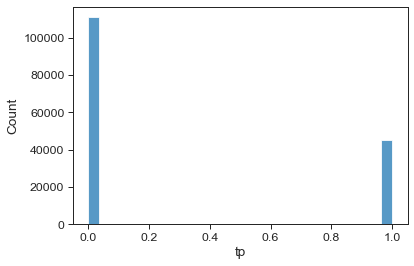

In [17]:
sns.histplot(res["tp"])
np.sum(res["tp"])

44922

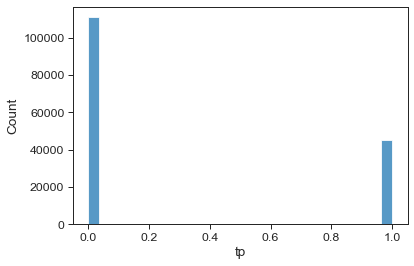

In [18]:
sns.histplot(res_01_["tp"])

np.sum(res_01_["tp"])



In [10]:
eff_005, res_005 = apply_thresholds(results_path, 0.05)

res_005_ = get_scores(res_005)

scCODA_results_203.pkl
scCODA_results_217.pkl
scCODA_results_377.pkl
scCODA_results_363.pkl
scCODA_results_388.pkl
scCODA_results_175.pkl
scCODA_results_161.pkl
scCODA_results_149.pkl
scCODA_results_47.pkl
scCODA_results_53.pkl
scCODA_results_84.pkl
scCODA_results_90.pkl
scCODA_results_91.pkl
scCODA_results_85.pkl
scCODA_results_52.pkl
scCODA_results_148.pkl
scCODA_results_46.pkl
scCODA_results_160.pkl
scCODA_results_174.pkl
scCODA_results_389.pkl
scCODA_results_362.pkl
scCODA_results_376.pkl
scCODA_results_216.pkl
scCODA_results_202.pkl
scCODA_results_214.pkl
scCODA_results_200.pkl
scCODA_results_360.pkl
scCODA_results_374.pkl
scCODA_results_348.pkl
scCODA_results_162.pkl
scCODA_results_78.pkl
scCODA_results_176.pkl
scCODA_results_50.pkl
scCODA_results_44.pkl
scCODA_results_93.pkl
scCODA_results_87.pkl
scCODA_results_189.pkl
scCODA_results_86.pkl
scCODA_results_188.pkl
scCODA_results_92.pkl
scCODA_results_45.pkl
scCODA_results_51.pkl
scCODA_results_79.pkl
scCODA_results_177.pkl
scCODA

44922

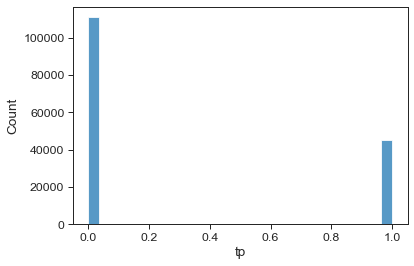

In [127]:
sns.histplot(res["tp"])
np.sum(res["tp"])

41282

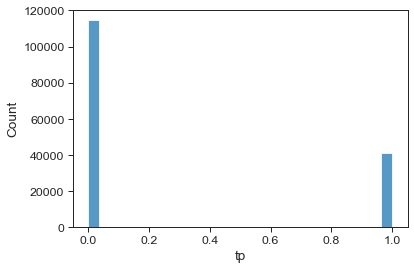

In [128]:
sns.histplot(res_005_["tp"])

np.sum(res_005_["tp"])


In [129]:
res_005_.to_csv(results_path + "benchmark_results_fdr_005")
eff_005.to_csv(results_path + "sccoda_effects_fdr_005")

res_005_grouped = res_005_.groupby(["n_controls", "n_cases", "Base", "Increase", "log-fold increase"]).agg(
    {"tp": "sum",
    "tn": "sum",
    "fp": "sum",
    "fn": "sum"}
).reset_index()

res_005_grouped = get_scores(res_005_grouped)

res_005_grouped.to_csv(results_path + "results_grouped_fdr_005.csv")

In [18]:
eff_01_ = eff_01.reset_index()
print(eff_01_)

        dataset Covariate Cell Type  Final Parameter  HDI 3%  HDI 97%     SD  \
0             0       x_0         0          0.00000  -0.211    1.070  0.388   
1             0       x_0         1          0.00000  -0.221    0.193  0.092   
2             0       x_0         2          0.00000  -0.086    0.342  0.114   
3             0       x_0         3          0.00000  -0.131    0.318  0.118   
4             0       x_0         4          0.00000   0.000    0.000  0.000   
...         ...       ...       ...              ...     ...      ...    ...   
779995   155999       x_0         0          0.92592  -0.004    1.448  0.370   
779996   155999       x_0         1          0.00000  -0.131    0.033  0.046   
779997   155999       x_0         2          0.00000  -0.037    0.116  0.042   
779998   155999       x_0         3          0.00000  -0.053    0.052  0.030   
779999   155999       x_0         4          0.00000   0.000    0.000  0.000   

        Inclusion probability  Expected

In [43]:
eff_02, res_02 = apply_thresholds(results_path, 0.2)

res_02_ = get_scores(res_02)

res_02_.to_csv(results_path + "benchmark_results_fdr_02")

scCODA_results_203.pkl
scCODA_results_217.pkl
scCODA_results_377.pkl
scCODA_results_363.pkl
scCODA_results_388.pkl
scCODA_results_175.pkl
scCODA_results_161.pkl
scCODA_results_149.pkl
scCODA_results_47.pkl
scCODA_results_53.pkl
scCODA_results_84.pkl
scCODA_results_90.pkl
scCODA_results_91.pkl
scCODA_results_85.pkl
scCODA_results_52.pkl
scCODA_results_148.pkl
scCODA_results_46.pkl
scCODA_results_160.pkl
scCODA_results_174.pkl
scCODA_results_389.pkl
scCODA_results_362.pkl
scCODA_results_376.pkl
scCODA_results_216.pkl
scCODA_results_202.pkl
scCODA_results_214.pkl
scCODA_results_200.pkl
scCODA_results_360.pkl
scCODA_results_374.pkl
scCODA_results_348.pkl
scCODA_results_162.pkl
scCODA_results_78.pkl
scCODA_results_176.pkl
scCODA_results_50.pkl
scCODA_results_44.pkl
scCODA_results_93.pkl
scCODA_results_87.pkl
scCODA_results_189.pkl
scCODA_results_86.pkl
scCODA_results_188.pkl
scCODA_results_92.pkl
scCODA_results_45.pkl
scCODA_results_51.pkl
scCODA_results_79.pkl
scCODA_results_177.pkl
scCODA

NameError: name 'eff_005' is not defined

In [44]:
eff_02.to_csv(results_path + "sccoda_effects_fdr_02")

res_02_grouped = res_02_.groupby(["n_controls", "n_cases", "Base", "Increase", "log-fold increase"]).agg(
    {"tp": "sum",
    "tn": "sum",
    "fp": "sum",
    "fn": "sum"}
).reset_index()

res_02_grouped = get_scores(res_02_grouped)

res_02_grouped.to_csv(results_path + "results_grouped_fdr_02.csv")

51071

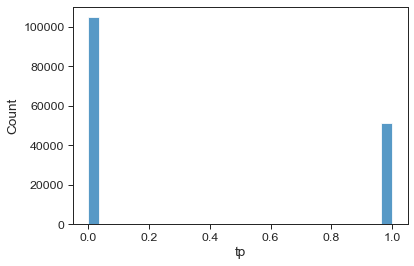

In [45]:
sns.histplot(res_02_["tp"])

np.sum(res_02_["tp"])











In [22]:

files = [x for x in os.listdir(results_path) if x.startswith("scCODA_results")]
sim_columns = ['n_cell_types', 'n_cells', 'n_controls',
               'n_cases', 'Base', 'Increase',
               'log-fold increase', 'b_true', 'w_true']
thresholds = np.round(np.arange(0.01, 1., 0.01), 2)

def recalculate_inc_prob(inc_probs, threshold):
    return [p > threshold for p in inc_probs]

def apply_thresholds_to_results(files, thresholds):
    threshold_dict = {}
    for t in thresholds:
        threshold_dict[t] = pd.DataFrame(columns=sim_columns + ["threshold", "tp", "tn", "fp", "fn"])
    i = 1

    # Iterate Over all files
    for file in files:
        if i%10 == 0:
            print(f"file {i}/{len(files)}")

        # open file
        with open(results_path + file, "rb") as f:
            d = pkl.load(f)

        # For each threshold
        for t in thresholds:

            # Prepare df to append to threshold_dict entry
            out_df = d["results"].loc[:, sim_columns]
            out_df["threshold"] = t

            tp_list = []
            tn_list = []
            fp_list = []
            fn_list = []

            # Iterate over all datasets in file
            for eff in d["effects"]:

                # no. of cell types
                K = eff.shape[0]
                ks = list(range(K))[1:]

                # calculate significances
                is_significant = recalculate_inc_prob(eff["Inclusion probability"], t)

                # Get tp, tn, fp, fn (Truth: Only first cell type significant)
                tp = sum([is_significant[0] == True])
                tp_list.append(tp)
                fn = sum([is_significant[0] == False])
                fn_list.append(fn)
                tn = sum([is_significant[k] == False for k in ks])
                tn_list.append(tn)
                fp = sum([is_significant[k] == True for k in ks])
                fp_list.append(fp)

            # add tp, tn, fp, fn to output df
            out_df["tp"] = tp_list
            out_df["tn"] = tn_list
            out_df["fp"] = fp_list
            out_df["fn"] = fn_list

            # append to threshold_dict entry
            threshold_dict[t] = threshold_dict[t].append(out_df, ignore_index=True)

        i += 1


    # Get scores (mcc, ...) for all thresholds
    for k,v in threshold_dict.items():
        if (k * 10) % 10 ==0:
            print(f"get scores: {k}")
        threshold_dict[k] = get_scores(v)

    return threshold_dict

In [23]:
threshold_dict = apply_thresholds_to_results(files, thresholds)

# Just an example
print(threshold_dict[0.3])

file 10/312
file 20/312
file 30/312
file 40/312
file 50/312
file 60/312
file 70/312
file 80/312
file 90/312
file 100/312
file 110/312
file 120/312
file 130/312
file 140/312
file 150/312
file 160/312
file 170/312
file 180/312
file 190/312
file 200/312
file 210/312
file 220/312
file 230/312
file 240/312
file 250/312
file 260/312
file 270/312
file 280/312
file 290/312
file 300/312
file 310/312
       n_cell_types n_cells n_controls n_cases Base Increase  \
0                 5    5000          2       9   20       80   
1                 5    5000          2       9   20       80   
2                 5    5000          2       9   20       80   
3                 5    5000          2       9   20       80   
4                 5    5000          2       9   20       80   
...             ...     ...        ...     ...  ...      ...   
155995            5    5000          8       8   30       70   
155996            5    5000          8       8   30       70   
155997            5    5000   

In [24]:
total_df = pd.concat(threshold_dict.values(), ignore_index=True)

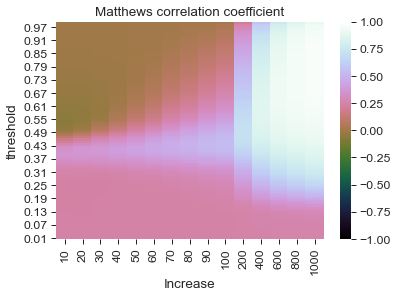

In [35]:
plot_df_mcc = total_df.groupby(["Increase", "threshold"]).agg({"mcc": "mean"}).unstack(level=0)
plot_df_mcc.columns = plot_df_mcc.columns.droplevel(0)

ax = sns.heatmap(data=plot_df_mcc, vmin=-1, vmax=1, cmap="cubehelix")
ax.invert_yaxis()


plt.xlabel("Increase")
plt.title("Matthews correlation coefficient")

# plt.savefig(plot_path + "threshold_determination_mcc.png", format="png")
# plt.savefig(plot_path + "threshold_determination_mcc.svg", format="svg")

plt.show()

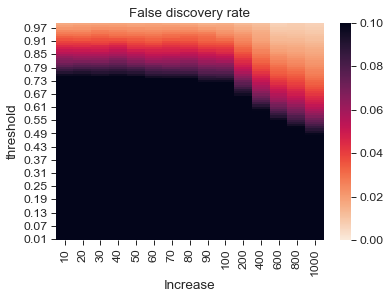

In [38]:
plot_df_fdr = total_df.groupby(["Increase", "threshold"]).agg({"fdr": "mean"}).unstack(level=0)
plot_df_fdr.columns = plot_df_fdr.columns.droplevel(0)

ax = sns.heatmap(data=plot_df_fdr, vmin=0, vmax=0.1, cmap="rocket_r")
ax.invert_yaxis()


plt.xlabel("Increase")
plt.title("False discovery rate")

# plt.savefig(plot_path + "threshold_determination_fdr.png", format="png")
# plt.savefig(plot_path + "threshold_determination_fdr.svg", format="svg")

plt.show()

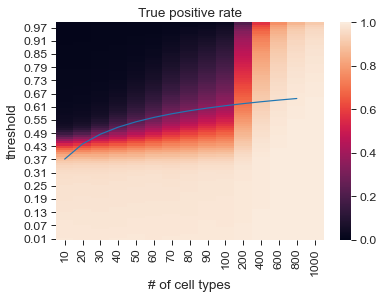

In [33]:
plot_df_tpr = total_df.groupby(["Increase", "threshold"]).agg({"tpr": "mean"}).unstack(level=0)
plot_df_tpr.columns = plot_df_tpr.columns.droplevel(0)

ax = sns.heatmap(data=plot_df_tpr, vmin=0, vmax=1)
ax.invert_yaxis()


plt.xlabel("Increase")
plt.title("True positive rate")

# plt.savefig(plot_path + "threshold_determination_tpr.png", format="png")
# plt.savefig(plot_path + "threshold_determination_tpr.svg", format="svg")

plt.show()

In [42]:
for t, res in threshold_dict.items():
    print(f"{t}: FDR {np.mean(res['fdr'])}")

0.01: FDR 0.7481314102564103
0.02: FDR 0.747963141025641
0.03: FDR 0.7477820512820512
0.04: FDR 0.7476362179487182
0.05: FDR 0.7474711538461538
0.06: FDR 0.7472895299145299
0.07: FDR 0.7470956196581195
0.08: FDR 0.7468039529914529
0.09: FDR 0.7465379273504272
0.1: FDR 0.7462029914529913
0.11: FDR 0.7456864316239314
0.12: FDR 0.7447911324786325
0.13: FDR 0.7431324786324787
0.14: FDR 0.7404610042735043
0.15: FDR 0.7365779914529915
0.16: FDR 0.7313856837606838
0.17: FDR 0.7251607905982905
0.18: FDR 0.7181842948717948
0.19: FDR 0.7104503205128205
0.2: FDR 0.7025202991452992
0.21: FDR 0.6943461538461538
0.22: FDR 0.6862094017094019
0.23: FDR 0.6782029914529913
0.24: FDR 0.6699465811965811
0.25: FDR 0.6617280982905983
0.26: FDR 0.653534722222222
0.27: FDR 0.6452398504273504
0.28: FDR 0.6368530982905982
0.29: FDR 0.6279647435897436
0.3: FDR 0.6182120726495726
0.31: FDR 0.6075934829059829
0.32: FDR 0.5960325854700854
0.33: FDR 0.5823360042735043
0.34: FDR 0.5670416666666666
0.35: FDR 0.5503306